# Beijing Air Quality Forecasting

## Project Overview
Predict PM2.5 concentrations in Beijing using LSTM networks for time series forecasting.

**Objective**: Achieve RMSE < 4000 on Kaggle leaderboard  
**Dataset**: 30,677 hourly observations (2010-2013) with weather features and PM2.5 concentrations  
**Approach**: Time series analysis, feature engineering, and systematic LSTM experimentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Setup submission tracking system
def save_submission(predictions, experiment_name, test_index):
    """Save submission with timestamp and experiment info"""
    os.makedirs('submissions', exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })
    
    filename = f'submissions/submission_{timestamp}.csv'
    submission.to_csv(filename, index=False)
    
    print(f"Submission saved: {filename}")
    print(f"Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    
    return filename, submission

print("Submission tracking ready!")


Submission tracking ready!


In [3]:
# Load datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")
print(f"\nColumns: {list(train.columns)}")


Training data: (30676, 12)
Test data: (13148, 11)

Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


# Data Exploration

Analyze the dataset structure, temporal patterns, and feature relationships.

In [4]:
# Basic data analysis
print("Data types:")
print(train.dtypes)

print("\nBasic statistics:")
print(train.describe().round(3))

print("\nMissing values:")
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
print("Training:", missing_train[missing_train > 0])
print("Test:", missing_test[missing_test > 0])

print("\nFirst few rows:")
train.head()

Data types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Basic statistics:
              No       DEWP       TEMP       PRES        Iws         Is  \
count  30676.000  30676.000  30676.000  30676.000  30676.000  30676.000   
mean   15338.500     -0.029     -0.063      0.014      0.031      0.017   
std     8855.543      0.994      1.015      1.009      1.018      1.087   
min        1.000     -2.135     -2.578     -2.381     -0.469     -0.069   
25%     7669.750     -0.888     -0.939     -0.823     -0.442     -0.069   
50%    15338.500     -0.057      0.045     -0.044     -0.353     -0.069   
75%    23007.250      0.913      0.865      0.833      0.005     -0.069   
max    30676.000      1.814      2.341      2.878     11.232     35.440   

              Ir    cbwd_NW    cbwd_SE 

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
# Process datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

print(f"Time range - Train: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"Time range - Test: {test['datetime'].min()} to {test['datetime'].max()}")

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00


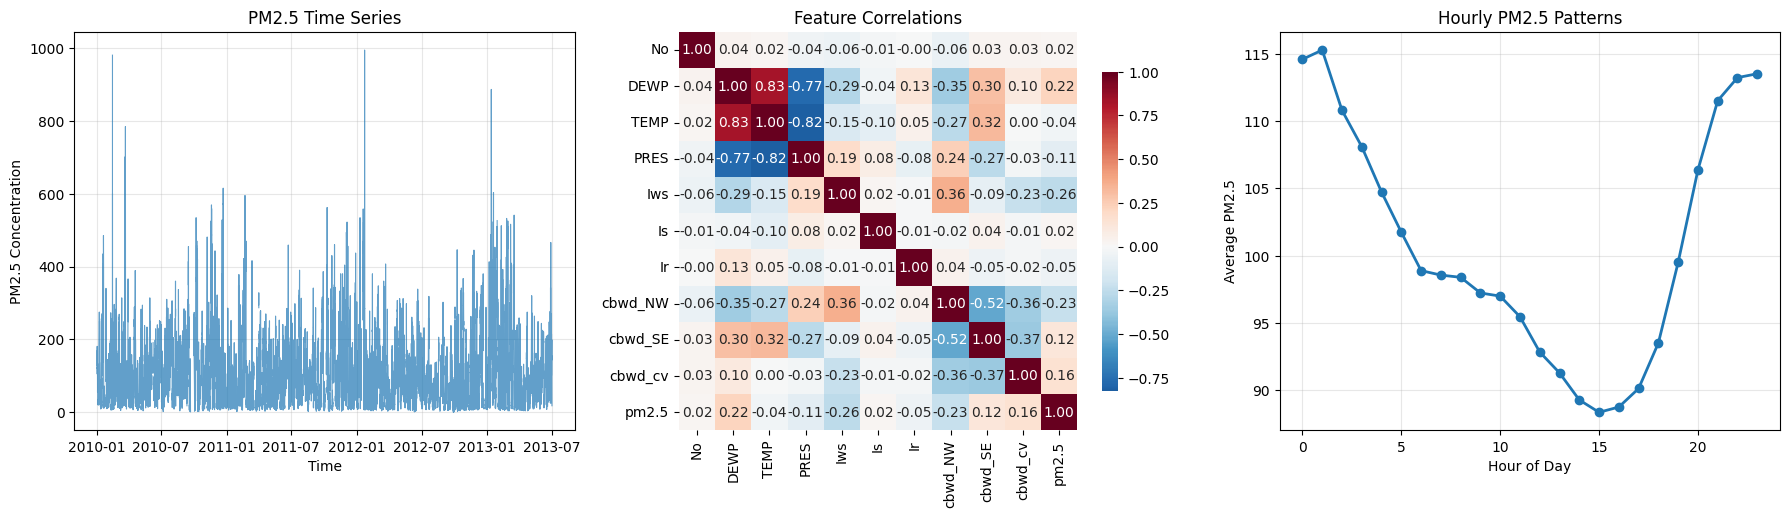

Key insights:
PM2.5 mean: 100.8, std: 93.1
Peak hour: 1:00, Lowest hour: 15:00


In [6]:
# Add key visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time Series Plot
axes[0].plot(train.index, train['pm2.5'], alpha=0.7, linewidth=0.8)
axes[0].set_title('PM2.5 Time Series')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 Concentration')
axes[0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.2f')
axes[1].set_title('Feature Correlations')

# 3. Hourly Patterns
hourly_avg = train.groupby(train.index.hour)['pm2.5'].mean()
axes[2].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[2].set_title('Hourly PM2.5 Patterns')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Average PM2.5')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("Key insights:")
print(f"PM2.5 mean: {train['pm2.5'].mean():.1f}, std: {train['pm2.5'].std():.1f}")
print(f"Peak hour: {hourly_avg.idxmax()}:00, Lowest hour: {hourly_avg.idxmin()}:00")


# Data Preprocessing

Handle missing values using time series appropriate methods.

In [7]:
# Handle missing values with forward fill and interpolation
train_clean = train.copy()
test_clean = test.copy()

# For PM2.5, use forward fill then backward fill
if 'pm2.5' in train_clean.columns:
    train_clean['pm2.5'] = train_clean['pm2.5'].fillna(method='ffill').fillna(method='bfill')

# For other features, use forward fill, backward fill, then interpolation
feature_cols = [col for col in train_clean.columns if col not in ['pm2.5', 'No']]
for col in feature_cols:
    train_clean[col] = train_clean[col].fillna(method='ffill').fillna(method='bfill')
    train_clean[col] = train_clean[col].interpolate(method='linear')

# Same treatment for test data
for col in test_clean.columns:
    if col != 'No':
        test_clean[col] = test_clean[col].fillna(method='ffill').fillna(method='bfill')
        test_clean[col] = test_clean[col].interpolate(method='linear')

# Verify results
print(f"Missing values after treatment:")
print(f"Training: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f"Clean datasets ready - Train: {train_clean.shape}, Test: {test_clean.shape}")


Missing values after treatment:
Training: 0, Test: 0
Clean datasets ready - Train: (30676, 11), Test: (13148, 10)


# Model Preparation

Separate features and target, then prepare data for LSTM.

In [8]:
# Separate features and target from clean data
X_train = train_clean.drop(['pm2.5', 'No'], axis=1)
y_train = train_clean['pm2.5']

print(f"Features shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Feature columns: {list(X_train.columns)}")

# Scale features for better training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f"Scaled features shape: {X_train_scaled.shape}")

Features shape: (30676, 9)
Target shape: (30676,)
Feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
Scaled features shape: (30676, 9)


In [9]:
# Reshape data for LSTM input
# LSTM requires 3D input: (samples, timesteps, features)
# For now, add timesteps dimension of 1 (basic approach)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)

print(f"Reshaped for LSTM: {X_train_reshaped.shape}")
print("Shape explanation: (samples, timesteps, features)")

# Train/validation split
split_idx = int(0.8 * len(X_train_reshaped))
X_train_final, X_val_final = X_train_reshaped[:split_idx], X_train_reshaped[split_idx:]
y_train_final, y_val_final = y_train.values[:split_idx], y_train.values[split_idx:]

print(f"Training data: {X_train_final.shape}, {y_train_final.shape}")
print(f"Validation data: {X_val_final.shape}, {y_val_final.shape}")

Reshaped for LSTM: (30676, 1, 9)
Shape explanation: (samples, timesteps, features)
Training data: (24540, 1, 9), (24540,)
Validation data: (6136, 1, 9), (6136,)


# Model Building & Training

Build and train LSTM model with proper evaluation.

In [10]:
# Build enhanced LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile with Adam optimizer and RMSE metric
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Display model architecture
model.summary()

# Training callbacks for better performance
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12538.6953 - mae: 77.2227 - val_loss: 11732.1182 - val_mae: 70.1563 - learning_rate: 0.0010
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 6683.1924 - mae: 55.9582 - val_loss: 8997.9189 - val_mae: 60.9571 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 5814.1851 - mae: 52.2629 - val_loss: 8106.8267 - val_mae: 58.8514 - learning_rate: 0.0010
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5625.6504 - mae: 51.6873 - val_loss: 7786.8232 - val_mae: 57.7870 - learning_rate: 0.0010
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 5503.3325 - mae: 51.1245 - val_loss: 7528.5356 - val_mae: 57.1895 - learning_rate: 0.0010
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 5450.5127 - mae: 50.9191 - val_loss: 7349.3735 - val_mae: 56.7429 - learning_rate: 0.0010
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 5378.5771 

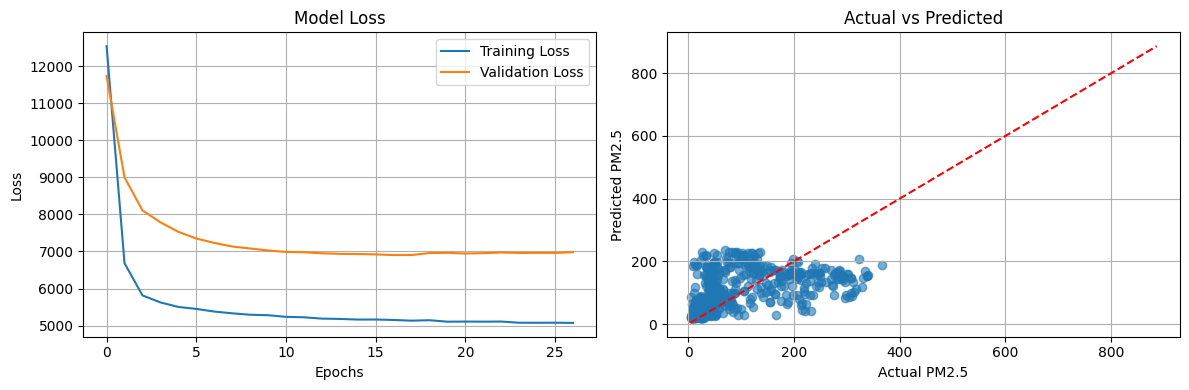

In [11]:
# Train the model with validation
print("Training model...")
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluate model performance
val_predictions = model.predict(X_val_final, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_final, val_predictions))

print(f"\nValidation RMSE: {val_rmse:.2f}")
print(f"Target RMSE: < 4000")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val_final[:500], val_predictions.flatten()[:500], alpha=0.6)
plt.plot([y_val_final.min(), y_val_final.max()], [y_val_final.min(), y_val_final.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Generate test predictions
print("Generating test predictions...")

# Prepare test data
X_test = test_clean.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

# Generate predictions
test_predictions = model.predict(X_test_reshaped, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f"Test predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}")

# Save submission using tracking system
filename, submission = save_submission(
    test_predictions, 
    f"enhanced_lstm_exp1", 
    test.index
)

print(f"\nSubmission ready: {filename}")
print("Sample predictions:")
print(submission.head())

Generating test predictions...
Test predictions - Min: 15.7, Max: 246.8
Submission saved: submissions/submission_20250921_224916.csv
Predictions - Min: 15.7, Max: 246.8

Submission ready: submissions/submission_20250921_224916.csv
Sample predictions:
               row ID  pm2.5
0  2013-07-02 4:00:00     72
1  2013-07-02 5:00:00     71
2  2013-07-02 6:00:00     67
3  2013-07-02 7:00:00     61
4  2013-07-02 8:00:00     55
